# Example 03  – $t$-$V$ model

In this example, we will study the dynamics of a system described by the t-V model, which is governed by the following Hamiltonian

$$
H = \underbrace{t\sum_i \left(e^{i\phi(t)}a_i^\dagger a_{i+1} + \text{h.c.}\right)}_{H_k} + V\sum_i n_i n_{i+1}, 
$$

Here, the Peierls phase is given by

$$
\phi(t) = -F \, t.
$$

The t-V model allows us to define a particle current operator, which can be derived using the continuity equation $\dot\rho + \text{div}\, j = 0$ and the Heisenberg picture. 
The expression for the current operator is as follows

$$
j_t = t\sum_i \left(i e^{i\phi(t)}a_i^\dagger a_{i+1} + \text{h.c.}\right).
$$

In the special case when $V=0$, the system has an analytical solution, and it can be shown that the relationship between the kinetic energy $\langle H_k\rangle$ and the current $\langle j_t \rangle$ is given by

$$
\begin{cases}
\langle j_t(t)\rangle \propto \sin(\frac 1F t)\\
\langle H_k(t)\rangle \propto \cos(\frac 1F t)
\end{cases}
$$

This result provides valuable insight into the behavior of the t-V model when the interaction term $V$ is absent. It demonstrates how the kinetic energy and current in the system oscillate periodically with time, governed by the parameter $F$.

In [1]:
import time as sys_time
import pystrel as ps
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from IPython.display import clear_output

In this tutorial, we have prepared a function called `simulate(**kwargs)` that implements all the necessary configurations and features required to study the quantum dynamics of the $t$-$V$ model.
Please note that often there are custom operators, which are not necessary universal, however, using `pystrel` one can define these through a separate model by using `build_hamiltonian` method. 

In this example we instantiate three models: 

- `model` for construction the Hamiltonian,
- `kinetic` for construction the kinetic part of the Hamiltonian,
- `current` for construction the particle current operator for the system.

Once the system is configured, we find the ground state:

```
psi = initial_state()
```

We then use this ground state as the initial state for propagation:

```
result = propagate(psi)
```

During the propagation, the user will also observe the current status of the simulation, displayed in the following format:

```
72.0% (elapsed time: 0:05:14.448733, remaining time: 0:02:02.285618)
```

Finally, the method will return the `result` as an `np.array` with columns representing time, $\langle H_k\rangle$, and $\langle j_t\rangle$, respectively.

> **Example**
> The following command will run the simulation for a system with $L=10$, $V=1$, and end time $T=5$. To see all supported `kwargs``, you can refer to about first 10 lines of the method implementation:
>
> ```
> result = simulate(L=10, V=1.0, T=5.0)
> ```

In [2]:
def simulate(**kwargs):
    start_time = sys_time.time()
    L = kwargs.get("L", 4)
    V = kwargs.get("V", 0.0)
    t = kwargs.get("t", 1.0)
    F = kwargs.get("F", 1.0)
    dt = kwargs.get("dt", 0.01)
    T = kwargs.get("T", 15.0)
    method = kwargs.get("methods", "cheb")
    sparsity = kwargs.get("sparsity", "sparse")
    dtype = np.complex128

    phi = lambda time: -F * time
    t_integral = lambda time: { (i, (i + 1) % L): np.exp(1.0j * phi(time)) * t for i in range(L) }
    jt = lambda time: {id: 1.0j * v for (id, v) in t_integral(time).items()}

    model = ps.Model({
        "sites": L,
        "terms": {
            "t": t_integral(0.0),
            "V": {(i, (i + 1) % L): V for i in range(L)},
        }
    })
    kinetic = ps.Model({"sites": L, "terms": {"t": t_integral(0.0)}})
    current = ps.Model({"sites": L, "terms": {"t": jt(0.0)}})

    def initial_state():
        h = model.build_hamiltonian(sparsity=sparsity, dtype=np.complex128)
        _, v = ps.spectrum.get_partial_spectrum(h, k=4)
        return v[0]

    def build_hamiltonian(time):
        model.update_terms({"t": t_integral(time)})
        return model.build_hamiltonian(sparsity=sparsity, dtype=dtype)

    def build_kinetic(time):
        kinetic.update_terms({"t": t_integral(time)})
        return kinetic.build_hamiltonian(sparsity=sparsity, dtype=dtype)

    def build_current(time):
        current.update_terms({"t": jt(time)})
        return current.build_hamiltonian(sparsity=sparsity, dtype=dtype)

    def measure_time(time, clear_time):
        current_sys_time = sys_time.time()
        if current_sys_time - clear_time > 0.5:
            clear_output(wait=True)
            prct = np.round(time / T * 100, 2)
            elapsed_time = timedelta(seconds=sys_time.time() - start_time)
            remaining_time = (100 - prct) / (prct+1e-9) * elapsed_time
            print(f"{prct}% (elapsed time: {elapsed_time}, remaining time: {remaining_time})")
            clear_time = current_sys_time
        return clear_time

    def propagate(psi):
        times, energies, currents = [], [], []
        time = 0
        clear_time = 0.0
        while time <= T:
            psi = ps.propagate(psi, build_hamiltonian, t0=time, dt=dt, method=method)
            energies.append(ps.measure(build_kinetic(time), psi).real)
            currents.append(ps.measure(build_current(time), psi).real)
            times.append(time)

            clear_time = measure_time(time, clear_time)

            time += dt
        return np.array([times, energies, currents])

    psi = initial_state()
    result = propagate(psi)
    return result

In [3]:
result_free = simulate(L=10, V=0.0)

100.0% (elapsed time: 0:07:10.640176, remaining time: 0:00:00)


In [4]:
result_int = simulate(L=10, V=1.0)

99.93% (elapsed time: 0:07:12.970169, remaining time: 0:00:00.303291)


As a result, in the parametric plot of ($\langle H_k\rangle$, $\langle j_t \rangle$), one can observe a perfect circle for the case of non-interacting fermions ($V=0$), and a spiral for interacting particles ($V=1$).

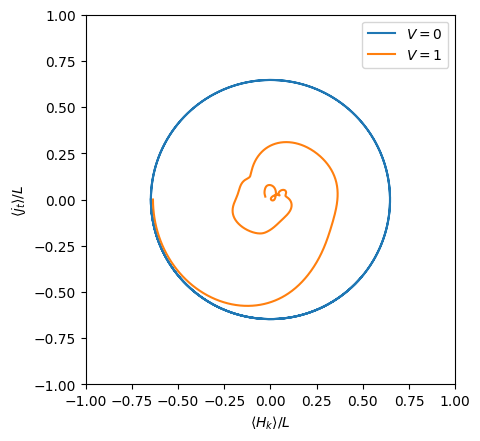

In [5]:
plt.gca().set_aspect("equal")
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.xlabel(r"$\langle H_k\rangle / L$")
plt.ylabel(r"$\langle j_t\rangle / L$")
plt.plot(result_free[1] / 10, result_free[2] / 10, label='$V=0$')
plt.plot(result_int[1] / 10, result_int[2] / 10, label='$V=1$')
plt.legend()
plt.show()